---
# Task 1: Explain dataset and business problems in two paragraphs.

**Data Understanding**:
The data is from the US FinTech company `LendingClub` ([Website](https://www.lendingclub.com)) that is located in San Fransisco and was founded in 2006. The company offers a peer-to-peer lending platform that is the world's largest one. It contains 2,260,701 total observations (data of borrowers / applicants) and 151 features such as the loan amount that the applicant requested, the interest rate he got and many more, but most importantly the loan status. A full list of the features can be seen [here](https://docs.google.com/spreadsheets/d/13mEvWhh5ju3gNFKn3wpB6gZ1erNHyCFNQFedGZrKcFo/edit#gid=1169809635). Since the data is not cleaned yet, we have to do several steps of preprocessing before we start with the EDA and with the default predictions.

**Business Understand**:
For the FinTech company it is crucial to detect whether a borrower is able to fully repay the loan or if she/he defaults. It can be very costly to approve a loan to someone that then defaults. Therefore, we can use Machine Learning and Explanatory Data Analysis (EDA) to recognize patterns that help us detect defaults and thus minimizes the risk of defaulting.

---
# Preprocessing
Preprocess and clean the data for further usage


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_theme(style='whitegrid')
pd.options.mode.chained_assignment = None  # Supress warning, default='warn'

## Load Data
Data can be downloaded from [Kaggle](https://www.kaggle.com/datasets/wordsforthewise/lending-club?datasetId=902). Information about the columns can be seen here on [Google Drive](https://drive.google.com/file/d/1UzyKMtrzL3aEEQpeYIz_qjBWyW-lAMr0/view).

In [2]:
# Read data
accepted_df = pd.read_csv(filepath_or_buffer="../data/raw/accepted_2007_to_2018Q4.csv")

C:\Users\Aless\AppData\Local\Temp\ipykernel_22000\3513952175.py:2: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_df = pd.read_csv(filepath_or_buffer="../data/raw/accepted_2007_to_2018Q4.csv")


In [3]:
# Get number of rows apriori of preprocessing
N = accepted_df.shape[0]

# Print information about raw datasets
print(f"Shape of accepted_df: {accepted_df.shape}")

Shape of accepted_df: (2260701, 151)


In [4]:
accepted_df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## NaNs Features Removal

In [5]:
# Compute fraction of NaNs in each Attribute
null_count_series = accepted_df.isna().sum().div(N)
# Sort descending
null_count_series = null_count_series.sort_values(ascending=False)

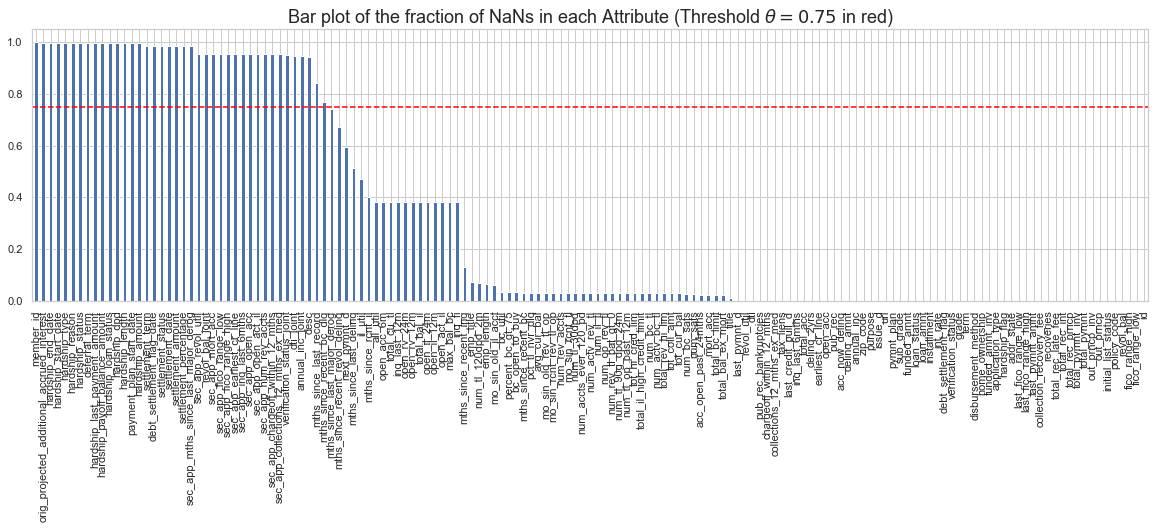

In [6]:
# Define threshold theta: Each column with more or equal NaNs than the threshold will be removed.
threshold = 0.75

plt.figure(figsize=(20,5))
plt.title(f"Bar plot of the fraction of NaNs in each Attribute (Threshold $\\theta = {threshold}$ in red)", size=18)
null_count_series.plot.bar()
# Add threshold as red line
plt.axhline(y=threshold, color="red", linestyle = "--")
plt.show()

In [7]:
# Remove all rows where the NaN Fraction is >= threshold.
null_count_series_cut = null_count_series[null_count_series.values < threshold]

In [8]:
# Get column names of the features with NaN fraction < threshold
columns_post_nan_cut = list(null_count_series_cut.index)
# Keep all columns in accepted_df that are in columns_post_nan_cut
accepted_df = accepted_df.drop([col for col in accepted_df.columns if col not in columns_post_nan_cut], axis=1)

In [9]:
accepted_df.head(5)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,...,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N


## Feature Cleaning

In [10]:
# Feature Cleaning
def clean_employment_length(value:str):
    """
    Function to clean and encode the attribute "emp_length"
    :param value: Content of the cell
    :return: Cleaned encoding, i.e. 0 for <1 year, and 10 for more than 10 years employment.
    """
    if value == "< 1 year":
        return 0.0
    if value == "10+ years":
        return 10.0
    if value == "nan":
        return np.nan
    else:
        # For the rest, i.e. values of the form "x years" -- keep only the numeric value
        return float(re.sub('[^0-9]','', str(value)))

# Remove "years" in "emp_length" and encode values according to the function defined above
accepted_df['emp_length'] = accepted_df['emp_length'].apply(lambda x: clean_employment_length(str(x)))

# Remove suffix in attribute "term"
accepted_df["term"] = accepted_df["term"].apply(lambda x: re.sub('[^0-9]','', str(x)))

## Categorical / Nominal Features
In this section we remove attributes / features that are nominal scaled and contain too many realizations. We do this since it is not feasible to encode attributes with this much realization. Also, the information gain keeping those attributes in would be insignificant.

In [11]:
print(accepted_df.dtypes.value_counts())
cat_columns_df = accepted_df.select_dtypes(include=['object']).astype('category')
# since loan status is the basis for implementing the target variable later on we exclude it from these transformations
cat_columns_df.drop('loan_status', inplace=True, axis='columns')
cat_columns = cat_columns_df.columns.tolist()

float64    87
object     24
dtype: int64


### Drop categorical features with too many realizations
We do this since it's not feasible to encode categorical features with too many realization, i.e. a variable with $K$ realizations produces $K-1$ dummy variables.

In [12]:
# Create DataFrame
cat_stats_df = pd.DataFrame()
# Append categorical columns to the df
cat_stats_df["column"] = cat_columns
# Append the number of unique objects in each categorical column to the df
cat_stats_df["n_unique_objects"] = [len(accepted_df[col].unique()) for col in cat_columns]
cat_stats_df["N"] = [len(accepted_df[col]) for col in cat_columns]
# Append the fraction of unique objects in each categorical column to the df
cat_stats_df["n_unique_objects_in_percent"] = cat_stats_df["n_unique_objects"] / cat_stats_df["N"]
# Sort descending
cat_stats_df.sort_values(by="n_unique_objects_in_percent", ascending=False)

,column,n_unique_objects,N,n_unique_objects_in_percent
0,id,2260701,2260701,1.000000
9,url,2260669,2260701,0.999986
4,emp_title,512695,2260701,0.226786
11,title,63156,2260701,0.027936
12,zip_code,957,2260701,0.000423
14,earliest_cr_line,755,2260701,0.000334
18,last_credit_pull_d,142,2260701,0.000063
7,issue_d,140,2260701,0.000062
16,last_pymnt_d,137,2260701,0.000061
17,next_pymnt_d,107,2260701,0.000047


**Result**:
We can see that there exist nominal attributes that have too much realization, such as 'id', 'url', 'emp_title', 'title', 'zip_code', and 'earlierst_cr_line'. Therefore, we drop all nominal columns that have more or equal than $\alpha=55$ of unique values.

In [13]:
# Set threshold
alpha = 55

# Get columns names to drop and drop them on the master df
nominal_columns_to_drop = cat_stats_df.query(f'n_unique_objects >= {alpha}').column
accepted_df.drop(nominal_columns_to_drop, axis=1, inplace=True)
print(f'Dropped nominal attributes are {nominal_columns_to_drop}')

Dropped nominal attributes are 0                     id
4              emp_title
7                issue_d
9                    url
11                 title
12              zip_code
14      earliest_cr_line
16          last_pymnt_d
17          next_pymnt_d
18    last_credit_pull_d
Name: column, dtype: object


## Create Target
In this section we build our binary target variable based on the attribute 'loan_status'. The target is either 1, if the owner of the loan defaulted, and 0 otherwise.

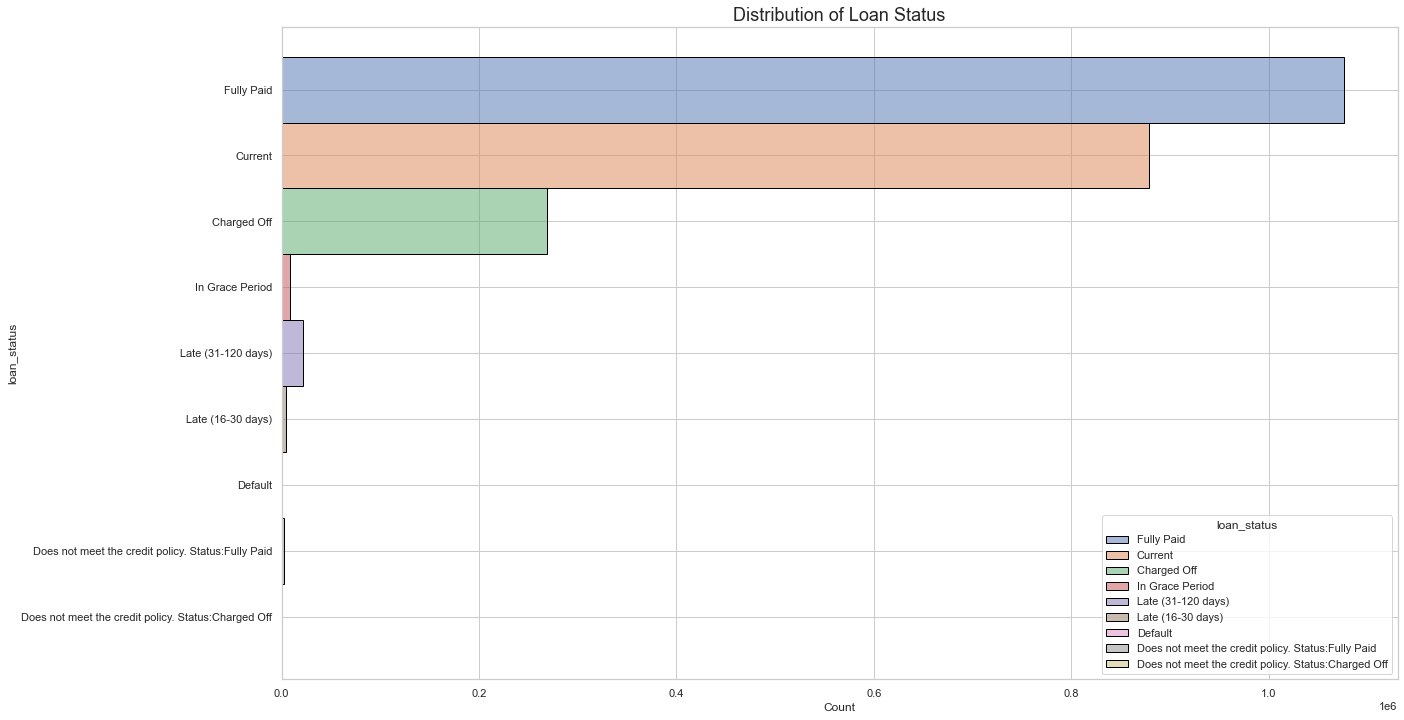

In [14]:
# Preview of the distribution of loan_status realizations
plt.figure(figsize=(20,12))
plt.title("Distribution of Loan Status", size=18)
ax = sns.histplot(data=accepted_df, y="loan_status", edgecolor="black", hue="loan_status")
sns.move_legend(ax, loc="lower right")
plt.show()

We are only interested in objects that either have 'Fully Paid' or 'Charged Off' as their loan status. Therefore, we filter for these realizations.
Afterwards, we encode
- 'Fully Paid' as a 0 (default) and
- 'Charged Off' as a 1 (non default).

We use this encoding for our binary classifier and predictor.

In [15]:
# Keep only objects with 'Fully Paid' or 'Charged Off' realization in loan_status.
accepted_df = accepted_df.query('(loan_status == "Fully Paid") | (loan_status == "Charged Off")')
# Preview binary distribution
accepted_df.loan_status.value_counts()
accepted_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,10.0,MORTGAGE,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,10.0,MORTGAGE,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,20000.0,20000.0,20000.0,60,10.78,432.66,B,B4,10.0,MORTGAGE,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
4,10400.0,10400.0,10400.0,60,22.45,289.91,F,F1,3.0,MORTGAGE,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
5,11950.0,11950.0,11950.0,36,13.44,405.18,C,C3,4.0,RENT,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N


In [16]:
# Replace 'Fully Paid' with 0, and 'Charged Off' with 1
accepted_df['loan_status'] = accepted_df['loan_status'].replace({"Fully Paid": 0, "Charged Off": 1})

# Set column 'loan_status' as integer
accepted_df['loan_status'] = accepted_df['loan_status'].astype(int)

In [17]:
# Preview final distribution of the loan status (target variable)
accepted_df.loan_status.value_counts()

0    1076751
1     268559
Name: loan_status, dtype: int64

# Save preprocessed dataframe
After our preprocessing, we save our dataframe into 'data/preprocessed' for later access of our EDA and Prediction Notebooks.

In [18]:
accepted_df.to_pickle('../data/preprocessed/accepted_df_preprocessed.pkl')